In [33]:
import pandas as pd
import numpy as np

import nltk
import html
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer,WordNetLemmatizer
import re
import unicodedata
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from statistics import mean
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import word_tokenize
from sklearn import preprocessing



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Data Cleaning

In [ ]:

# takes a list of tweets and outputs a list of the cleaned tweets
def tweetcleaning(tweet_lst):
    
    # remove URLs
    tweet_lst_clean = [re.sub(r"http\S+", "", tw) for tw in tweet_lst]
    
    # remove all HTML tags and replace all HTML character codes with ASCII
    tweet_lst_clean = [tw.encode('ascii', 'ignore').decode('ascii') for tw in tweet_lst_clean]
    
    # remove retweet segment from retweets
    for i in range(len(tweet_lst_clean)):
        if tweet_lst_clean[i][:2] == 'RT':
            tweet_lst_clean[i] = tweet_lst_clean[i].split(' ', 2)[2]
            
    # remove user mentions (@)
    tweet_lst_clean = [re.sub(r"(?:\@|https?\://)\S+", "", tw) for tw in tweet_lst_clean]
    
    # remove all numbers and other special characters
    regex = re.compile('[^a-zA-Z ]')
    tweet_lst_clean = [regex.sub('', tw) for tw in tweet_lst_clean]
    
    # change all characters to lowercase
    tweet_lst_clean = [tw.lower() for tw in tweet_lst_clean]
    
    # remove stop words using nltk stopwords library
    stop_words = set(stopwords.words('english'))
    for i in range(len(tweet_lst_clean)):
        example_sent = tweet_lst_clean[i]
        word_tokens = word_tokenize(example_sent)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        filtered_sentence = []
        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)
        tweet_lst_clean[i] = ' '.join(filtered_sentence)
        
    return(tweet_lst_clean)

In [ ]:
df_sent = pd.read_csv('sentiment_analysis.csv')
tweet_lst_sent = tweetcleaning(df_sent['text'].tolist())
df_sent['clean text'] = tweet_lst_sent

clean_text_lst = []
for words in df_sent['clean text']:
  clean_text_lst.append(words.split())

df_sent['clean text list'] = clean_text_lst

#lemmatize the words
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatize tokens
lemmatizer = WordNetLemmatizer()
df_sent['lemmatized'] = df_sent['clean text list'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x])
# Convert the lemmatized words back to the text format
df_sent['clean text'] = [' '.join(map(str, l)) for l in df_sent['lemmatized']]
df_sent[['text', 'clean text']]

,text,clean text
0,Josh Jenkins is looking forward to TAB Breeder...,josh jenkins look forward tab breeder crown su...
1,RT @MianUsmanJaved: Congratulations Pakistan o...,congratulation pakistan become notestteam worl...
2,"RT @PEPalerts: This September, @YESmag is taki...",september take maine mendozas surprise thanksg...
3,"RT @david_gaibis: Newly painted walls, thanks ...",newly paint wall thanks million custodial pain...
4,RT @CedricFeschotte: Excited to announce: as o...,excite announce july feschotte lab relocate mbg
...,...,...
550386,@goddesses_o I can't stop watching her...mm. M...,cant stop watch hermm
550387,Poor old Tom Odell doesn't look like he would ...,poor old tom odell doesnt look like would know...
550388,#antsmasher I smashed 7 ants in this awesome ...,antsmasher smash ant awesome gamehjfjfi
550389,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,morning girl wonderful friday


In [ ]:
df_elect = pd.read_csv('Canadian_elections_2021.csv')
tweet_lst_elect = df_elect['text'].tolist()
tweet_lst_elect = [tw[1:] for tw in tweet_lst_elect]
tweet_lst_elect = tweetcleaning(tweet_lst_elect)
df_elect['clean text'] = tweet_lst_elect

clean_text_lst = []
for words in df_elect['clean text']:
  clean_text_lst.append(words.split())

df_elect['clean text list'] = clean_text_lst

# Lemmatize tokens
lemmatizer = WordNetLemmatizer()
df_elect['lemmatized'] = df_elect['clean text list'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x])
# Convert the lemmatized words back to the text format
df_elect['clean text'] = [' '.join(map(str, l)) for l in df_elect['lemmatized']]
df_elect[['text', 'clean text']]

,text,clean text
0,The Canadian election is a power grab by PM Tr...,canadian election power grab pm trudeau yes ta...
1,I do hope Trudeau loses the Canadian election ...,hope trudeau loses canadian election tomorrow ...
2,"Dear Canadians, This election is a test of how...",ear canadian election test progressive whether...
3,Canadian friends: Never forget that Trudeau ha...,anadian friend never forget trudeau year manda...
4,Sorry @theJagmeetSingh I have voted #NDP all m...,orry vote ndp life election fight freedom cana...
...,...,...
997,This is absolutely horrible in Canada. The for...,absolutely horrible canada forthcoming electio...
998,@davidakin Trudeau imposes gun control policie...,davidakin trudeau imposes gun control policy u...
999,In Canada 🇨🇦 our election is being stolen by t...,n canada election steal thug uneducated goon d...
1000,"O'Toole amends platform on gun control, but qu...",toole amends platform gun control question rem...


#Exploratory analysis

In [35]:
def party(text, sentiment):
    
    #define the words that show political inclination
    l_lst = ['justin','trudeau','justintrudeau','liberal','forwardforeveryone']
    
    c_lst = ['erinotoole','conservative','cpc',"o'toole"]
    
    n_lst = ['jagmeet','singh','thejagmeetsingh','newdemocratic','ndp','fightingforyou']

    p_lst = ['maxime','bernier','maximebernier','ppopulaireca','peoplespca']
    
    category = []

    #identify the political party based on lists of keywords
    for word in text.split():
        for l_key_word in l_lst:
            if word in l_key_word:
                category.append('liberal')
        for c_key_word in c_lst:
            if word in c_key_word:
              category.append('conservative')
        for n_key_word in n_lst:
            if word in n_key_word:
              category.append('new democratic party')
        for p_key_word in p_lst:
            if word in p_key_word:
              category.append("the people's party of Canada")
                
    # If there are multiple parties mentioned, return the party mentioned most frequently
    if len(category) > 1:
        most_frequent = max(set(category), key=category.count)
        category = []
        category.append(most_frequent)
        
    # If there is no party mentioned in the list, return None 
    elif len(category) == 0:
        category.append('None')
    
    #return value rather than list
    return category[0] 

In [36]:
# add a column to df_elect to show political partty
df_elect['political party']=list(map(party,df_elect['clean text'], df_elect['sentiment']))

df_elect

,Unnamed: 0,text,sentiment,negative_reason,clean text,clean text list,lemmatized,political party
0,0,The Canadian election is a power grab by PM Tr...,negative,calling election early,canadian election power grab pm trudeau yes ta...,"['canadian', 'election', 'power', 'grab', 'pm'...","['canadian', 'election', 'power', 'grab', 'pm'...",liberal
1,1,I do hope Trudeau loses the Canadian election ...,negative,covid,hope trudeau loses canadian election tomorrow ...,"['hope', 'trudeau', 'loses', 'canadian', 'elec...","['hope', 'trudeau', 'loses', 'canadian', 'elec...",liberal
2,2,"Dear Canadians, This election is a test of how...",positive,,ear canadian election test progressive whether...,"['ear', 'canadians', 'election', 'test', 'prog...","['ear', 'canadian', 'election', 'test', 'progr...",liberal
3,3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early,anadian friend never forget trudeau year manda...,"['anadian', 'friends', 'never', 'forget', 'tru...","['anadian', 'friend', 'never', 'forget', 'trud...",liberal
4,4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,,orry vote ndp life election fight freedom cana...,"['orry', 'voted', 'ndp', 'life', 'election', '...","['orry', 'vote', 'ndp', 'life', 'election', 'f...",new democratic party
...,...,...,...,...,...,...,...,...
997,997,This is absolutely horrible in Canada. The for...,negative,others,absolutely horrible canada forthcoming electio...,"['absolutely', 'horrible', 'canada', 'forthcom...","['absolutely', 'horrible', 'canada', 'forthcom...",None
998,998,@davidakin Trudeau imposes gun control policie...,negative,gun control,davidakin trudeau imposes gun control policy u...,"['davidakin', 'trudeau', 'imposes', 'gun', 'co...","['davidakin', 'trudeau', 'imposes', 'gun', 'co...",liberal
999,999,In Canada 🇨🇦 our election is being stolen by t...,negative,others,n canada election steal thug uneducated goon d...,"['n', 'canada', 'election', 'stolen', 'thugs',...","['n', 'canada', 'election', 'steal', 'thug', '...",new democratic party
1000,1000,"O'Toole amends platform on gun control, but qu...",negative,tell lies,toole amends platform gun control question rem...,"['toole', 'amends', 'platform', 'gun', 'contro...","['toole', 'amends', 'platform', 'gun', 'contro...",conservative


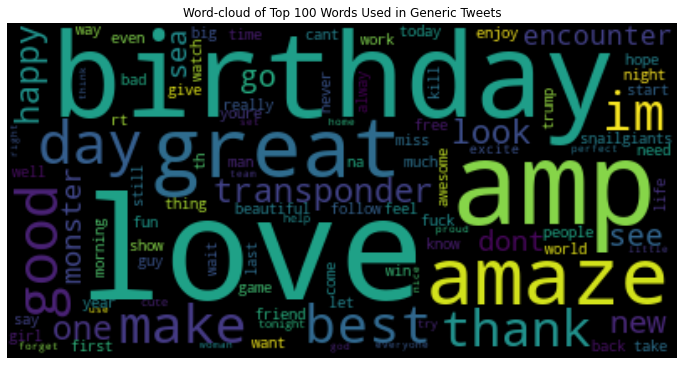

In [ ]:
#Word Cloud for sentiment analysis
tweet_str="".join(df_sent['clean text'])
wordcloud=WordCloud(max_words = 100, collocations=False).generate(tweet_str)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title("Word-cloud of Top 100 Words Used in Generic Tweets")
plt.axis('off')
plt.show()

The image indicates the frequency of words being used by size among all the generic tweets. As the graph shows, most of the most frequent use words have positive meaning in most cases.

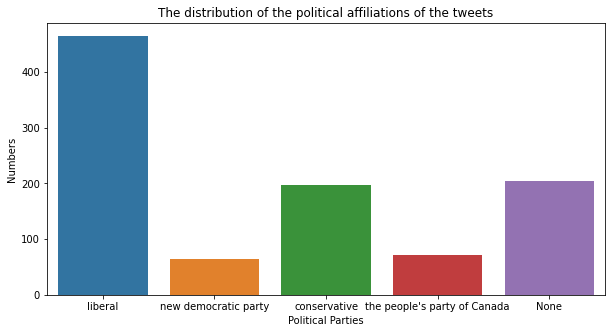

In [ ]:
# Countplot of political parties
plt.figure(figsize=(10,5))
ax = sns.countplot(x='political party',data=df_elect)
ax.axes.set_title('The distribution of the political affiliations of the tweets')
ax.set_xlabel('Political Parties')
ax.set_ylabel('Numbers')
plt.show()

This graph is the count plot of the different political affiliations of the tweets during 2021. The Liberal and the Conservative has the most counts in the first and the second place, which aligns with the votes rank in 2021. A huge part in distribution is recognized as None. It indicates that huge amount of tweets doesn’t want to show their political affiliations.

In [ ]:
df_sent.to_csv('new_sentiment_analysis.csv')
df_elect.to_csv('new_Canada_elections_2021.csv')

#Sentiment Classification - Model implementation and tuning 

a) Machine learning models

In [34]:
df_elect = pd.read_csv('new_Canadian_elections_2021.csv')
df_sent = pd.read_csv('new_sentiment_analysis.csv')
df_elect = df_elect.replace(np.nan, '', regex=True)
df_sent = df_sent.replace(np.nan, '', regex=True)

In [37]:

def tf_idf(corpus):
    
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(corpus)
    
    return X

X_sent_tf_idf = tf_idf(df_sent['clean text'])
y_sent = df_sent['label']
X_train_sent_tf_idf, X_test_sent_tf_idf, y_train_sent_tf_idf, y_test_sent_tf_idf = train_test_split(X_sent_tf_idf, y_sent, random_state=1, test_size=0.2)

In [ ]:
models = {'lr': LogisticRegression(),'knn': KNeighborsClassifier(),'svm':LinearSVC(), 'nb':MultinomialNB(),'dt': DecisionTreeClassifier(),'rf': RandomForestClassifier(),'XGB':XGBClassifier()}

def run_model(model_name, model, X_train, y_train, X_test, y_test):
        
    # Fit to training set
    model.fit(X_train, y_train)
        
    # Make predictions on testing set
    test_predictions = model.predict(X_test)

    acc_test = accuracy_score(y_test, test_predictions)

    print('Accuracy score for',model_name,":",acc_test)
    
    return acc_test, model

for name, model in models.items():
    models[name] = run_model(name,model,X_train_sent_tf_idf,y_train_sent_tf_idf,X_test_sent_tf_idf,y_test_sent_tf_idf)

Accuracy score for lr : 0.9417600087210095
Accuracy score for knn : 0.8765977161856485
Accuracy score for svm : 0.9413057894784654
Accuracy score for nb : 0.901198230361831
Accuracy score for dt : 0.9311585316000327
Accuracy score for rf : 0.9454846065098702
Accuracy score for XGB : 0.8651695600432416


b) Deep learning model

In [ ]:
def bag_of_words(corpus):
    
    vectorizer = CountVectorizer(max_features=1000)
    X = vectorizer.fit_transform(corpus).toarray()

    
    return X

X_sent_bag = bag_of_words(df_sent['clean text'])
y_sent_bag = df_sent['label']
X_train_sent_bag, X_test_sent_bag, y_train_sent_bag, y_test_sent_bag = train_test_split(X_sent_bag, y_sent_bag, random_state=1, test_size=0.2)
X_train_sent_bag, X_val_sent_bag, y_train_sent_bag, y_val_sent_bag = train_test_split(X_train_sent_bag, y_train_sent_bag, random_state=1, test_size=0.25)


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout,SpatialDropout1D
from keras.layers import Dense
from keras.layers import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
# import dill as pickle
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=1000, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=30000, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_sent_bag, y_train_sent_bag)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Due to the frequent crashing on google colab, I have to jump over this part.

c) Evaluate the trained model with the best performance (considering all models from part a) and part b)) on the Canadian Elections data.

The model with the best perfomance is random forest.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_elect['sentiment'])

model = RandomForestClassifier()
model.fit(X_train_sent_tf_idf, y_train_sent_tf_idf)


RandomForestClassifier()

In [ ]:
X_elections_tf_idf = tf_idf(df_elect['clean text'])
y_elections_sentiment = pd.Series(le.transform(df_elect['sentiment']))
predictions_rf = model.predict(X_elections_tf_idf)
score_rf = accuracy_score(y_elections_sentiment,predictions_rf)

In [ ]:
print("Accuracy: %.3f" % (score_rf))

Accuracy: 0.490


The predictions match the sentiment labelled in the Canadian elections data at a low accuracy rate of 49%, which is not a good performance.

d) Propose two other evaluation metrics you could use to evaluate the models.

In [ ]:
results = classification_report(y_elections_sentiment,predictions_rf)
print(results)

              precision    recall  f1-score   support

           0       0.35      0.36      0.35       387
           1       0.59      0.57      0.58       615

    accuracy                           0.49      1002
   macro avg       0.47      0.47      0.47      1002
weighted avg       0.49      0.49      0.49      1002



Compare to 0, the precisison for 1 is higher, which means the proportion of predicted Positives is truly positive in 1, is better than in 0. 

Compare to 0, the recall for 1 is also higher, which means the proportion of actual Positives is correctly classified in 1, is better than in 0.

e) Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 4 parties.

<function matplotlib.pyplot.show>

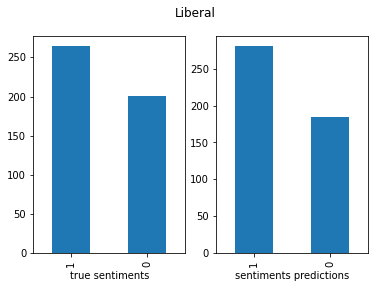

In [38]:
df_elect['pred'] = predictions_rf
df_elect['true'] = y_elections_sentiment

liberal = df_elect.loc[df_elect['political party']=='liberal']

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Liberal')
plt1 = plt.subplot(121) 
liberal['true'].value_counts().plot.bar() 
plt1.set_xlabel('true sentiments')
plt.sca(plt1)

plt2 = plt.subplot(122)  
liberal['pred'].value_counts().plot.bar() 
plt2.set_xlabel('sentiments predictions')
plt.sca(plt2)
plt.show

<function matplotlib.pyplot.show>

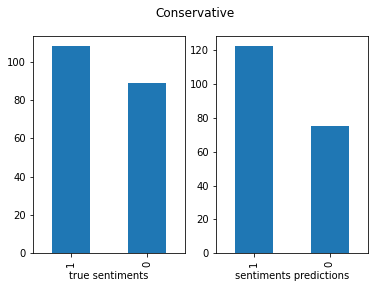

In [39]:
conservative = df_elect.loc[df_elect['political party']=='conservative']

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Conservative')
plt1 = plt.subplot(121) 
conservative['true'].value_counts().plot.bar() 
plt1.set_xlabel('true sentiments')
plt.sca(plt1)

plt2 = plt.subplot(122)  
conservative['pred'].value_counts().plot.bar() 
plt2.set_xlabel('sentiments predictions')
plt.sca(plt2)
plt.show

<function matplotlib.pyplot.show>

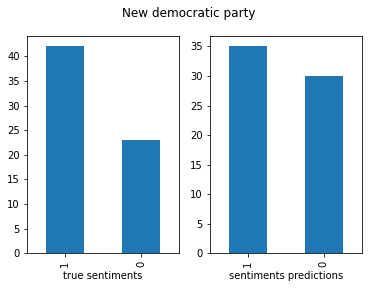

In [40]:
new_d = df_elect.loc[df_elect['political party']=='new democratic party']

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('New democratic party')
plt1 = plt.subplot(121) 
new_d['true'].value_counts().plot.bar() 
plt1.set_xlabel('true sentiments')
plt.sca(plt1)

plt2 = plt.subplot(122)  
new_d['pred'].value_counts().plot.bar() 
plt2.set_xlabel('sentiments predictions')
plt.sca(plt2)
plt.show

<function matplotlib.pyplot.show>

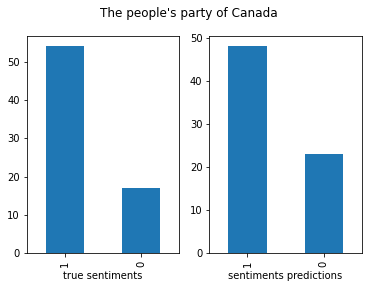

In [41]:
ppc = df_elect.loc[df_elect['political party']=="the people's party of Canada"]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("The people's party of Canada")
plt1 = plt.subplot(121) 
ppc['true'].value_counts().plot.bar() 
plt1.set_xlabel('true sentiments')
plt.sca(plt1)

plt2 = plt.subplot(122)  
ppc['pred'].value_counts().plot.bar() 
plt2.set_xlabel('sentiments predictions')
plt.sca(plt2)
plt.show

I think NLP analytics based on tweets is useful for political parties during election campaigns. It can help the party to understand the public's sentiment on itself and its oppoents, so the party cna figure out where it can improve and plan for the mext step. 

Both Conservative and Liberal only have a small gap between positive and negative sentiments from public view, while other two parties have much more higher positive sentiments than the negative sentiments.

One way to improve the accuracy, is to increase the accurate key words to identify people's political affiliations on different parties.

#Negative Reason Classification - Model implementation and tuning

In [ ]:
df_elect_negative = df_elect.assign()
df_elect_negative.drop(df_elect_negative.loc[df_elect_negative['sentiment']=='positive'].index, inplace=True)
temp_lst = df_elect_negative['text'].tolist()
temp_lst = [tw[1:] for tw in temp_lst]
temp_lst = tweetcleaning(temp_lst)
X_elections_tf_idf_negative = tf_idf(temp_lst)
le2 = preprocessing.LabelEncoder()
le2.fit(df_elect_negative['negative_reason'])
y_elections_negative = pd.Series(le2.transform(df_elect_negative['negative_reason']))
X_train_elections_tf_idf_negative, X_test_elections_tf_idf_negative, y_train_elections_tf_idf_negative, y_test_elections_tf_idf_negative = train_test_split(X_elections_tf_idf_negative, y_elections_negative, random_state=2, test_size=0.3)

# hyparparameter tuning for logistic regression model
best_ACC = 0
print('logistic regression:')
for C in [0.01,0.1,1,1000,10000]:
    model = LogisticRegression(C=C)
    scores = cross_val_score(model, X_train_elections_tf_idf_negative, y_train_elections_tf_idf_negative, cv=5)
    mean_ACC = scores.mean()
    print('C =', C, ", accuracy:", round(mean_ACC*100,2), "%")
    if mean_ACC > best_ACC:
        best_C = C
        best_ACC = mean_ACC

logistic regression:
C = 0.01 , accuracy: 41.11 %
C = 0.1 , accuracy: 41.11 %
C = 1 , accuracy: 44.44 %
C = 1000 , accuracy: 48.52 %
C = 10000 , accuracy: 49.26 %


a) Provide a few reasons why your model may fail to predict the correct negative reasons.

"Others" as a reason, may have multile meanings, which decrease the accruacy of the model. Also, "scandal" and "tell lies" tend to have the same meaning, which also can confuse the model's learning process.

b) Suggest one way you can improve the accuracy of your selected model.

Increase the TF-IDF features of the model may help to increase the efficiency.

c) Feel free to combine similar reasons into fewer categories as long as you justify your reasoning.

Combine the words "scandal" and "tell lies", because they basically have the same meaning and the bad influences.